In [1]:
# load  the model
# load  the dataloaders
# see what the model is and how the model is being used

In [2]:
import sys
import os

# Add project root (one directory up from notebooks)
sys.path.append(os.path.abspath('..'))


In [3]:
import torch


# model related
from models.fff_model import resnet, MLP, brazy_encoder, brazy_decoder, cond_conv_encoder, cond_conv_decoder, FreeFormFlow, condFreeFormFlow, ImprovedCNN
from models.architectures_fff import BrazyConfig, get_encoder_and_decoder

# model training related
from models.feature_extractor_creator import train_feature_extractor

#data related
from data.dataloaders_related import get_mnist_dataloaders

# plotting related
from utils.plotting import  five_samples_same_model_during_training
import matplotlib.pyplot as plt


# trainer
from training.trainer import train_model_mnist, test_model

# 
import tqdm
from typing import Literal
from dataclasses import dataclass
from typing import Literal, Union, Tuple, Any

In [4]:
device= 'cpu'#"cuda" if torch.cuda.is_available() else "cpu"
print(device)

pixelwidth = 28

cpu


In [ ]:
# mlp_cfg = MLPConfig(pixelwidth=28, fff_dim=128, fff_layers=3)
# resnet_cfg = ResNetConfig(pixelwidth=28, fff_dim=128, fff_layers=2, fff_resnet_blocks=4)
brazy_cfg = BrazyConfig(
    fff_c_small = 32,
    fff_f1_dim = 256,
    fff_f2_dim = 512,
    third_convolutional_layer = True,
    fff_batchnorm = False,
    fff_dropout = 0.1
)

encoder, decoder = get_encoder_and_decoder("brazy", brazy_cfg, device=device)
# get the model
fours_fff = FreeFormFlow(encoder, decoder, device=device, data_dims=pixelwidth**2).to(device)
fours_fff

FreeFormFlow(
  (encoder): brazy_encoder(
    (dropout): Dropout(p=0.1, inplace=False)
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=6272, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=512, bias=True)
    (latent): Linear(in_features=512, out_features=784, bias=True)
    (batchnorm1): Identity()
    (batchnorm2): Identity()
  )
  (decoder): brazy_decoder(
    (dropout): Dropout(p=0.1, inplace=False)
    (fc2): Linear(in_features=784, out_features=512, bias=True)
    (fc1): Linear(in_features=512, out_features=256, bias=True)
    (fc_to_conv): Linear(in_features=256, out_features=6272, bias=True)
    (deconv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (deconv2): ConvTranspose2d(64, 32, kernel_size=(3,

### Training some feature extractors

In [6]:
# Hyperparameters
batch_size_feat_extractor = 63
learning_rate_feat_extractor= 0.001
epochs_feat_extractor = 5

# DataLoaders
train_loader, test_loader = get_mnist_dataloaders(batchsize=batch_size_feat_extractor, pixelwidth=28, digit=4)
zero_one_train_loader, zero_one_test_loader = get_mnist_dataloaders(batchsize=batch_size_feat_extractor, pixelwidth=28, digit=4, zero_one_range=True)

# Train both models
fid_feature_extractor = train_feature_extractor(
    ImprovedCNN, train_loader, device, learning_rate_feat_extractor, epochs_feat_extractor
)

# zero_one_fid_feature_extractor = train_feature_extractor(
#     ImprovedCNN, zero_one_train_loader, device, learning_rate_feat_extractor, epochs_feat_extractor
# )

# Evaluate the model on test data
test_model(fid_feature_extractor, test_loader)
# test_model(zero_one_fid_feature_extractor, zero_one_test_loader)

Test Accuracy: 100.00%


In [7]:
#STR+UP+7: multi line comment in qwertz type 

### Training the FFF model

In [8]:
# code to fix: fix the check_acfff_classification_quality thingy (for the time being I have set it to False.)

In [9]:
# train the model
fours_fff, fours_fff_metrics, fours_fff_snapshots = train_model_mnist(fours_fff,
                                                    model_name="fff",
                                                    digit=4,
                                                    pixelwidth=pixelwidth,
                                                    epochs=100,
                                                    lr=0.0008,
                                                    batchsize=500,
                                                    beta_r=1.,
                                                    fid_feature_extractor=fid_feature_extractor,
                                                    ridge=None,
                                                    dequantization=None,
                                                    calculate_mmd=False,
                                                    calculate_fid=True,
                                                    weight_decay=1e-5,
                                                    lr_schedule=False,
                                                    calculate_is=False,
                                                    zero_one_range=False,
                                                    check_acfff_classification_quality=False)

In [10]:
import matplotlib.pyplot  as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import LogLocator
import numpy as np # This does not seem to be working. need to do 

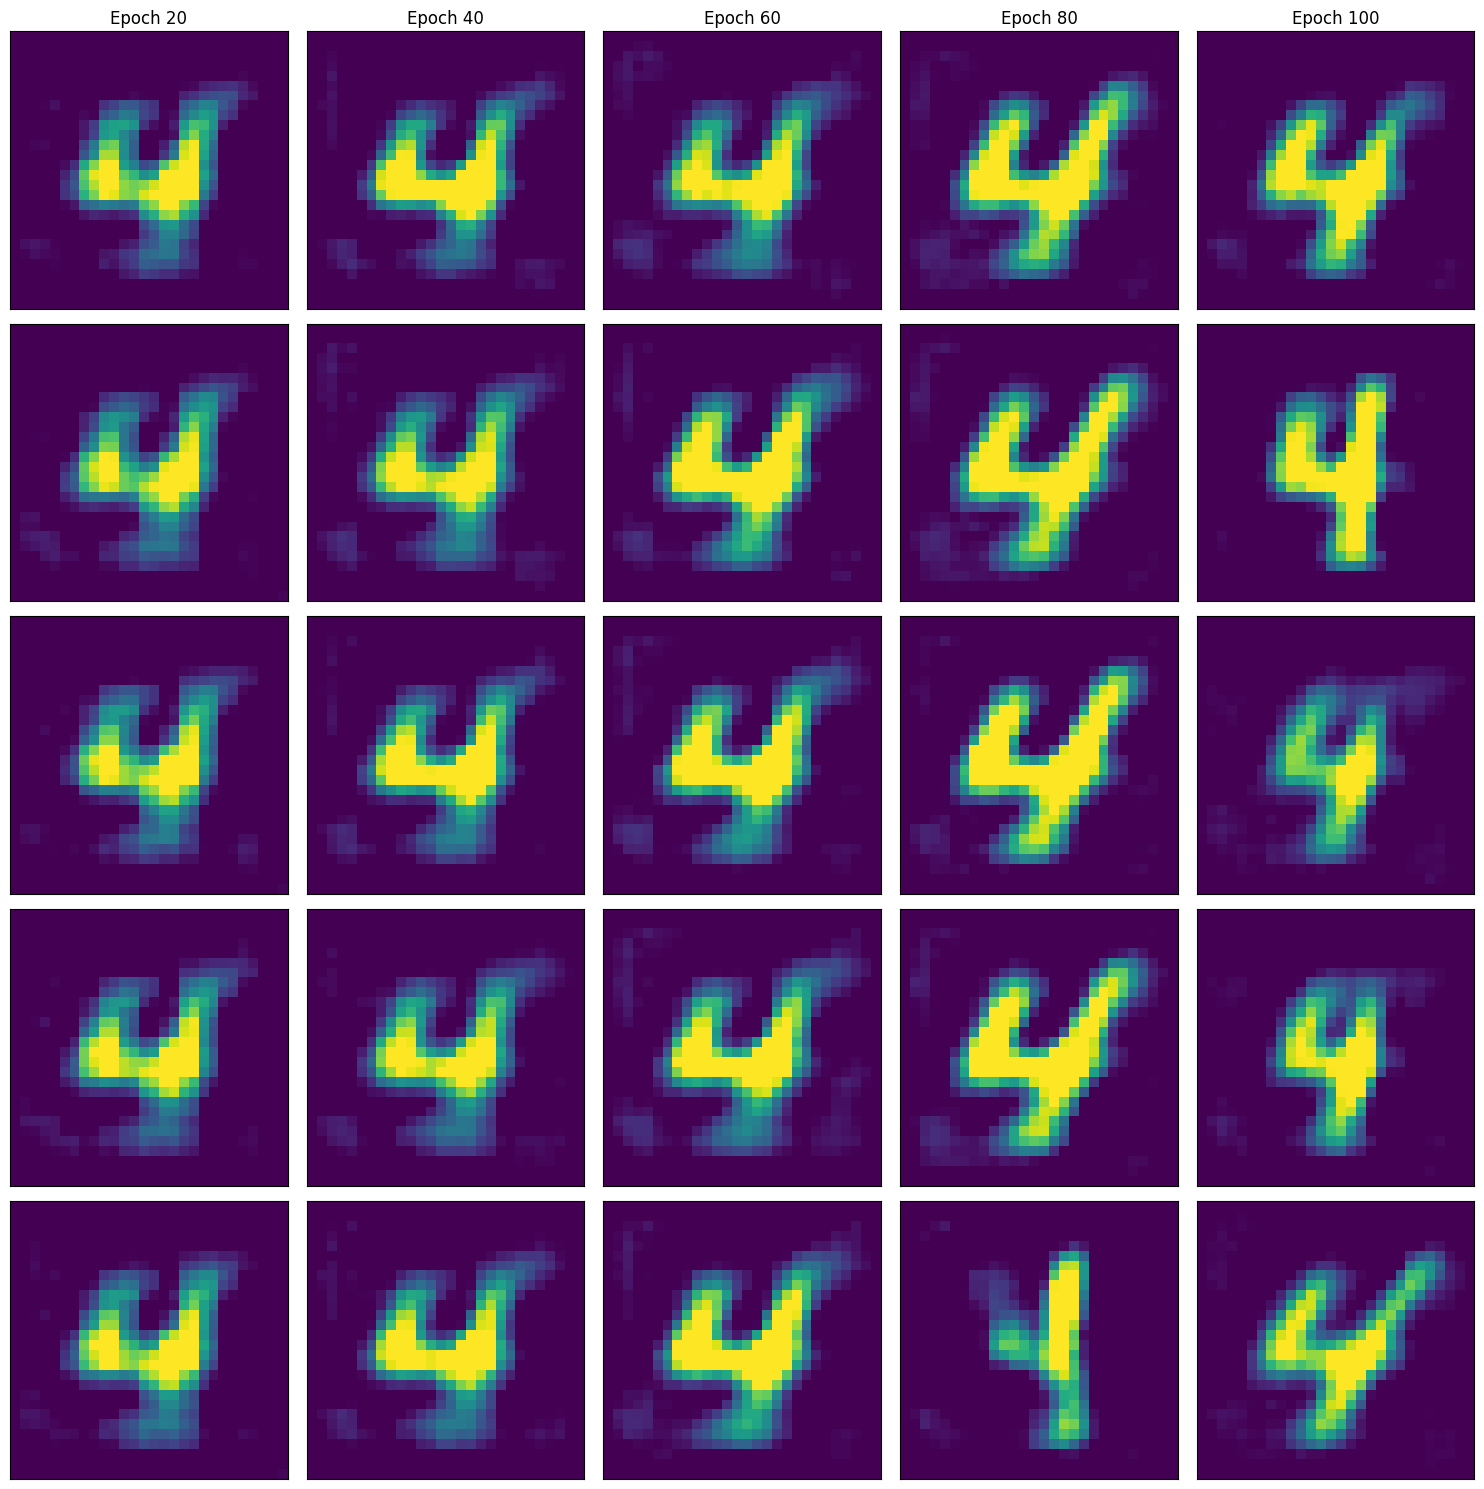

In [11]:
five_samples_same_model_during_training(fours_fff_snapshots, n_epochs=100)#, save_path="best_fours_samples.png")

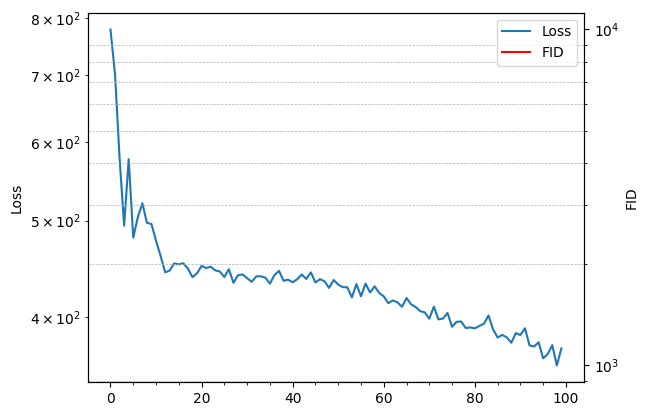

In [12]:
line1 = plt.plot(fours_fff_metrics["loss"], label="Loss")[0]
plt.yscale("log")
plt.ylabel("Loss")
ax = plt.twinx()
ax.set_yscale("log")
line2 = ax.plot(fours_fff_metrics["fid"][0], fours_fff_metrics["fid"][1], color="red", label="FID")[0]
ax.set_ylabel("FID")
plt.xlabel("Epochs")

lines = [line1,line2]
labels = [line.get_label() for line in lines]
plt.legend(lines, labels)

ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=10))  # Minor ticks

plt.grid(plt.grid(which='both', linestyle='--', linewidth=0.5))

ax.minorticks_on()

In [ ]:
def plot_sample(sample, pixelwidth=28, zero_one_range = True, figsize=(15,3)):
    plt.figure(figsize=figsize)
    #sample = model_in.sample(1)
    # if zero_one_range: vmin, vmax = 0., 1.
    # else: vmin, vmax = -0.447, 2.852
    # plt.matshow(sample.detach().numpy().reshape((pixelwidth,pixelwidth)), vmin=vmin, vmax=vmax)
    plt.imshow(sample.view(*(pixelwidth, pixelwidth)).cpu().numpy())

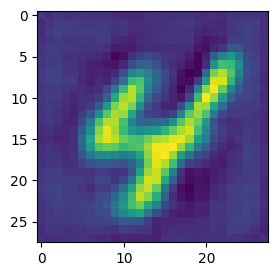

In [ ]:
# generating the digit
with torch.no_grad():
    z, generated = fours_fff.sample(num_samples=1,return_z = True)
    z.shape
    plot_sample(generated)

tasks to do:
1. create the dataset: half are fixed other half are gaussian noise. (latent distrn)
2. train a M-FFF 
geomstat: to define the manifold and try to understand what is being done there.

In [15]:
a = list(range(0,9))
remove_set = set([1,2,3])
result = [x for x in a if x not in remove_set]
result

[0, 4, 5, 6, 7, 8]

In [94]:
def topk_indices(image:torch.Tensor, already_selected_indices:list,topk:int):
    image[0, already_selected_indices] = -1e-9
    _, indices = torch.topk(image,topk)
    indices = list(indices[0])
    return indices
x = torch.tensor([[1,2,13,14,5,6]])
topk_indices(image=x,already_selected_indices=[2,3], topk=2)

[tensor(5), tensor(4)]

In [ ]:
def progressive_pixel_generation_max_vals(generator:FreeFormFlow, 
                                        num_steps:int=6, image_shape:Tuple[int, ...]=(28,28),
                                        selection_strat:Literal['topk', 'random'] = 'topk' ,
                                        top_n:int=10# this is for topk strategy and also used in number of choices
                                        ):

    all_chosen = []
    data_dims = generator.data_dims

    

    with torch.no_grad():

        # initial sample: shapes [1, latent_dim], [1, 784]
        z_old, gen = generator.sample(num_samples=1, return_z=True)# shape [1, 784]
        temp = gen.clone()
        plt.figure(figsize=(6,6))
        plot_sample(sample=gen)

        #for subplot figure
        rows = num_steps//2
        cols = 2
        _, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        axes = axes.flatten()

        for step in range(num_steps):
            # picking next top-n pixel positions
            # different strategies I need to add here: 1. topk, 2. random, 3. using some kind of correlation. 
            temp = gen.clone()
            if selection_strat == 'topk':
                pass
            elif selection_strat == 'random':
                a = list(range(0,z_old.shape[1]))
                remove_set = set(all_chosen)
                remaining_list = [x for x in a if x not in remove_set]
                new_idx = np.random.choice(remaining_list, size= top_n)
            elif selection_strat == 'correlation_based':
                pass
            #print(f'new_idx is: {new_idx}')
            all_chosen.extend(new_idx)

            
            a = list(range(0,z_old.shape[1]))
            remove_set = set(all_chosen)
            remaining_indxs = [x for x in a if x not in remove_set]
            #gen[0, all_chosen] = torch.min(gen) 
            gen[0, remaining_indxs] = torch.min(gen)

            
            # plot the old image ( now I think only a few pixels would be a fewer pixels in each step, with number of such pixels also increasing in each step)
            ax = axes[step]
            ax.imshow(gen.view(*image_shape).cpu().numpy())
            ax.set_title(f"Step {step+1}")
            ax.axis("off")

            # next step sampling:
            # resampling a fresh latent vector
            z_new, _ = generator.sample(num_samples=1, return_z=True)
            # copying latent values for the chosen pixel positions
            z_new[0, all_chosen] = gen[0, all_chosen] # replacing some of the gaussian values sampled to the previous ones
            # decoding the modified latent vector
            gen_new = generator.decoder(z_new)[..., :data_dims]  # shape [1, 784]
            if torch.all(gen_new[0, all_chosen] == gen[0, all_chosen]):# this would always be the case
                gen_new[0, all_chosen] = gen[0, all_chosen]

            # for the next loop
            gen = gen_new
            z_old = z_new
            

        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(6,6))
        plot_sample(sample=gen)
        plt.title('final unmasking')
        plt.show()

        # MSE between the the initial generation and the final image
        mse = torch.mean((temp-gen)**2)
        print(f'mse between the initial most and the final image is: {mse}')

    return gen.view(1, *image_shape), all_chosen


<Figure size 600x600 with 0 Axes>

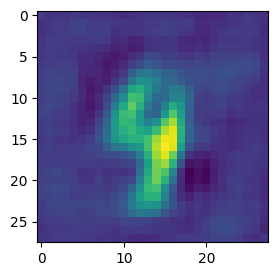

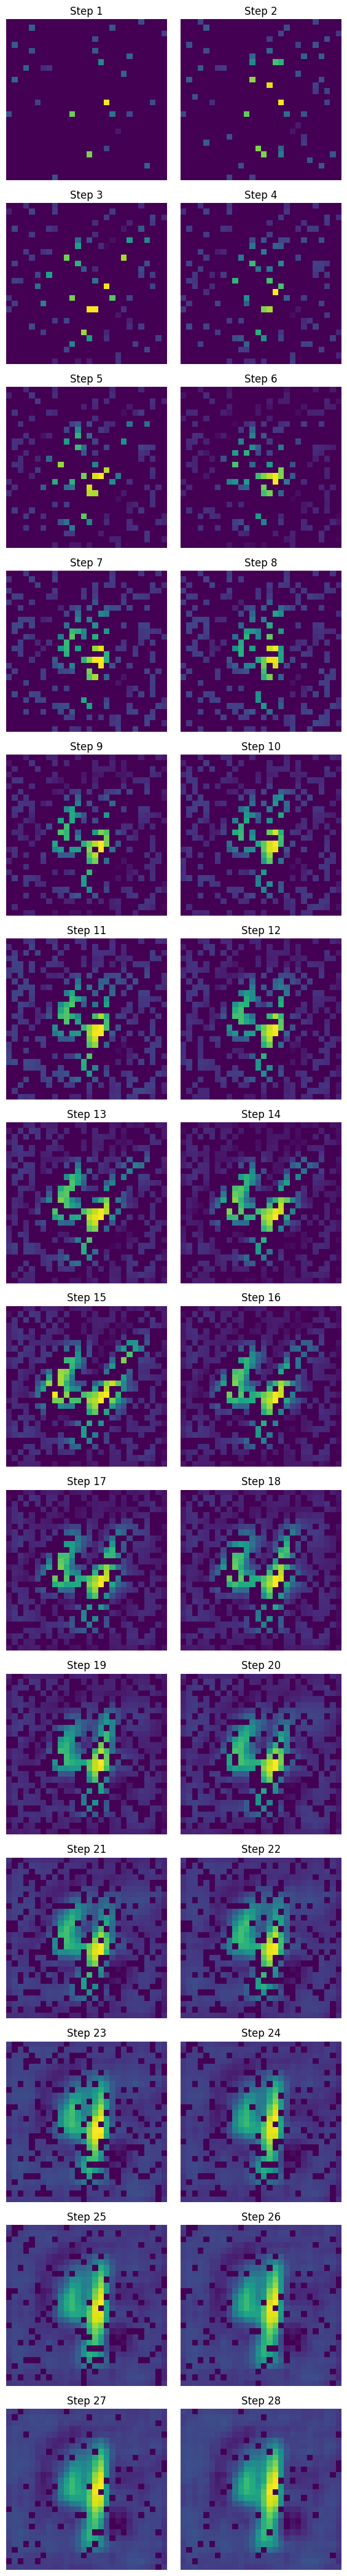

<Figure size 600x600 with 0 Axes>

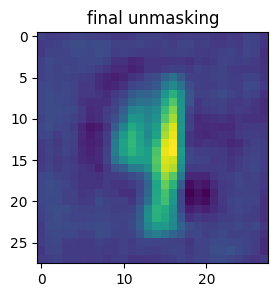

mse between the initial most and the final image is: 2.737624168395996
all chosen pixel indexes: 784


In [100]:
final_image, all_chosen_pixel_indexes = progressive_pixel_generation_max_vals(generator=fours_fff, top_n=28, num_steps=28, selection_strat='random'
                                                                           )
print(f'all chosen pixel indexes: {len(all_chosen_pixel_indexes)}')

In [ ]:
# some better kind of conditional generation is required
# learn the conditional vector in the middle to work on the thinG. 

